In this notebook, we will use classification algorithms to predict the number of rented bikes for a given day.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import tensorflow as ts
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

seed=99
random.seed(seed)
np.random.seed(seed)

2023-05-01 17:20:54.862142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Feature Engineering

Loading data from data_cleaning notebook:

In [2]:
rental = pd.read_csv('../data/rental.csv')

In [3]:
rental.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0,6,0.24,0.2879,0.81,0.0,16,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,1,6,0.22,0.2727,0.80,0.0,40,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1,2,6,0.22,0.2727,0.80,0.0,32,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,3,6,0.24,0.2879,0.75,0.0,13,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,4,6,0.24,0.2879,0.75,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Checking the distribution of the number of bikes rented each hour.

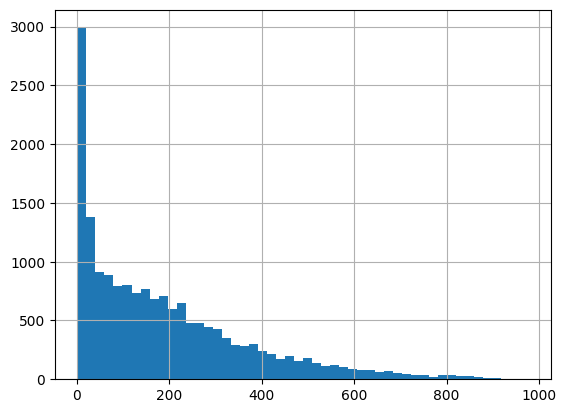

In [4]:
hist = rental['cnt'].hist(bins=50)

In [5]:
median = rental['cnt'].median()

print(f'Median of "cnt" feature {median:.4f}')

Median of "cnt" feature 142.0000


We want to create two new dataframes to use in the classification models. One for two-class classification and one for multi-class classification. The median of the "cnt" feature was 142. For the dataframe that we will use for two-class classification, this feature will be replaced with a feature with the value 1 if 142 or more bikes were rented that given hour and 0 if fewer than 142 bikes were rented that given hour. 

Most instances are between 0 and 200, which means that it was mostly a number of bikes between 0 and 200 that was rented for a given hour. Few instances were over 600, which means that rarely over 600 bikes were rented for a given hour. Therefore, we found it sufficient to classify the "cnt" feature into six diffrent categories for the dataframe we will use for the multi-class classification problems. We chose three splits for the range between 0 and 200 bikes, which was <50, 50-100 and 100-200, because most instances were found in this interval. The remaining categories are 200-400, 400-600 and >600.

#### Two-class classification dataframe:

In [6]:
two_class_df = rental.copy()

two_class_df['>=142'] = np.where(two_class_df['cnt']>=median, 1, 0)
two_class_df = two_class_df.drop(columns=['cnt'])

two_class_df.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,>=142
0,1,0,6,0.24,0.2879,0.81,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,1,1,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
2,1,2,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,1,3,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
4,1,4,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0


#### Multi-class classification dataframe:

In [7]:
multi_class_df = rental.copy()

labels = ['<50', '[50-100)', '[100-200)', '[200-400)', '[400-600)', '>600']
bins = [0,50,100,200,400,600, float('inf')]

multi_class_df['cnt_bins'] = pd.cut(multi_class_df['cnt'],bins=bins,labels=labels)

multi_class_df = multi_class_df.drop(columns=['cnt'])

multi_class_df.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,cnt_bins
0,1,0,6,0.24,0.2879,0.81,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,<50
1,1,1,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,<50
2,1,2,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,<50
3,1,3,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,<50
4,1,4,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,<50


The "cnt" feature is modified to fit different classification models. The two new dataframes, two_class_df and multi_class_df, will be used for classification under "Predictive modelling" to find out which model performes best for classifying the number of bikes rented based on data about the given day and weather conditions. We will start with multi-class classification to get the most accurate prediction. However, if the model does not perform significantly better than the baseline model and the previous models, we will use two-class classification.

# Predictive modeling

Creating two sets for 80% train data and 20% test data. One from the two_class_df dataframe with the feature ">=142" as target variable, and one for the multi_class_df with the feature "cnt_bins" as the target variable.

#### Train and test data for two-class classification:

In [8]:
X = two_class_df.loc[:, two_class_df.columns != '>=142']
y = two_class_df['>=142']

X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size=0.2)

#### Train and test data for multi-class classification

In [9]:
X = multi_class_df.loc[:, multi_class_df.columns != 'cnt_bins']
y = multi_class_df['cnt_bins']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.2)

## Baseline Model

We create two baseline models. One for multi-class classification and one for two-class classification. Both baseline models are DummyClassifiers that ignores the input features passed in as X and always predicts the most frequent class label in the y argument that is passed into fit.

#### Baseline model for two-class classification:

In [10]:
baseline = DummyClassifier(strategy='most_frequent', random_state=seed).fit(X_train_two, y_train_two)

train_score = baseline.score(X_train_two, y_train_two)
print(f'Predictive score on training data {train_score:.4f}')

test_score = baseline.score(X_test_two, y_test_two)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.5031
Predictive score on test data 0.4931


#### Baseline model for multi-class classification:

In [11]:
baseline = DummyClassifier(strategy='most_frequent', random_state=seed).fit(X_train_multi, y_train_multi)

train_score = baseline.score(X_train_multi, y_train_multi)
print(f'Predictive score on training data {train_score:.4f}')

test_score = baseline.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.2792
Predictive score on test data 0.2860


The accuracy of the two-class baseline model performes better than the multi-class baseline model. We expect the models to perform better with two-class classification, because it only has to assign the label to one of two classes. However, the multi-class classification will classify the output into more accurate bins. Therefore, we need to do a tradeoff between accuracy score and whether the classification is two-class or multi-class.

## Method 1: Logistic Regression

The first classification model we want to try is logistic regression. Logistic regression is used for two-class problems, and will map the class label to 1 if the number of bikes rented are 142 or more for the given hour and 0 if it's less than 142. Therefore, we will use the two_class_df dataframe.

#### Default model

In [12]:
clf = LogisticRegression(random_state=seed).fit(X_train_two, y_train_two)

train_score = clf.score(X_train_two, y_train_two)
print(f'Predictive score on training data {train_score:.4f}')

test_score = clf.score(X_test_two, y_test_two)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.7891
Predictive score on test data 0.7926


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We change the penalty to L1 norm, because our dataset consists of many features. We will also tune the C hyperparameter which specifies the strength of the regularization to see if we can improve the accuracy.

#### Finetuned model

In [13]:
clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')

param_grid = {'C':[0.5,1,1.5,2,2.5,3]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_two, y_train_two)

train_score = grid_search.best_estimator_.fit(X_train_two,y_train_two).score(X_train_two, y_train_two)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_two, y_test_two)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.7890
Predictive score on test data after modifications 0.7923


Changing the regularization technique to L1 norm and tuning the C parameter did not improve our model. However, the model performes significantly better on both the train data and test data compared to the baseline model for two-class classification. For about 79% of the test instances (hours), our model predicted correctly whether over or under 142 bikes were rented that given hour.

## Method 2: K-Nearest Neighbors

The next classification method we will use is K-Nearest Neighbors, which will label the instance based on the label that is most frequently found around the data point. If the majority of the k nearest neighbors of a data point is have 100-200 rented bikes for a given hours, the label for this data point will be 100-200. We will start by doing multi-class classification to try and get a more exact prediction of the number of rented bikes.

#### Default model

In [14]:
clf = KNeighborsClassifier().fit(X_train_multi, y_train_multi)

train_score = clf.score(X_train_multi, y_train_multi)
print(f'Predictive score on training data {train_score:.4f}')

test_score = clf.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.7550
Predictive score on test data 0.6191


The train and test score is significantly better compared to the baseline model for multi-class classification. The model performes better on the train data than the test data. Therefore, we will tune the number of neighbors to consider as well as "p", which is either manhattan distance or eucledian distance.

#### Finetuned model

In [15]:
clf = KNeighborsClassifier()

param_grid = {'n_neighbors':range(1,10), 'p':[1,2]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_multi, y_train_multi)

train_score = grid_search.best_estimator_.fit(X_train_multi, y_train_multi).score(X_train_multi, y_train_multi)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.7304
Predictive score on test data after modifications 0.6430


The results show that the test accuracy is slightly improved after tuning the parameters. 

Even though 64% test accuracy is significantly better than the 28% from the multi-class baseline model, we try to use the k-nearest neighbor algorithm with two-class classification to compare with the two-class baseline model and logistic regression.

In [16]:
clf = KNeighborsClassifier()

param_grid = {'n_neighbors':range(1,10), 'p':[1,2]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_two, y_train_two)

train_score = grid_search.best_estimator_.fit(X_train_two, y_train_two).score(X_train_two, y_train_two)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_two, y_test_two)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.9161
Predictive score on test data after modifications 0.8979


The accuracy for two-class classification (test: 89%) is significantly better than the accuracy for multi-class classification (test: 64%). This makes sense because it's only two different categories to choose from in the classification vs six categories when we used the multi_class_df dataframe. 

Two-class k-nearest neighbors classification also performed better than logistic regression (test: 79%) and the two-class baseline model (test: 49%).

## Method 3: Decision Trees

The third method we want to try out is desicion trees, which has nodes that performes tests on the features and each branch from the node repsesents the outcomes of the test. Again, we will start by using multi-class classification to try to get the most exact prediction, and check for two-class classification the first model doesn't perform significantly better than the baseline model and K-nearest neighbors.

#### Default model

In [17]:
clf = DecisionTreeClassifier(random_state=seed).fit(X_train_multi, y_train_multi)

train_score = clf.score(X_train_multi, y_train_multi)
print(f'Predictive score on training data {train_score:.4f}')

test_score = clf.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.9996
Predictive score on test data 0.6418


In [18]:
depth = clf.get_depth()
print(f'Depth of decision tree {depth:.4f}')

Depth of decision tree 39.0000


In [19]:
#figure = plt.figure(figsize=(25,20))
#tree_plt = tree.plot_tree(clf, max_depth=3, feature_names=X_train_multi.columns, class_names="cnt_bins", filled=True, fontsize=10)

The test score is about the same as for the tuned version of K-nearest neighbors. However, we can see that the model perform very well on the train data and not so well for the test data. This is a sign of overfitting. To prevent overfitting of decision trees, we want to prune the tree, i.e. prevent it from growing to its full depth. We want to perform pre-pruning, which involves tuning the hyperparameters. The hyperparameters we are going to prune are max_depth, min_samples_leaf and min_samples_split.

#### Finetuned model

In [20]:
clf = DecisionTreeClassifier(random_state=seed)

param_grid = {'max_depth':[5,10,15,20,25,20,35,39], 'min_samples_leaf':[1,2,3,4,5], 'min_samples_split':[2,4,6,8,10]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_multi, y_train_multi)

train_score = grid_search.best_estimator_.fit(X_train_multi, y_train_multi).score(X_train_multi, y_train_multi)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.8007
Predictive score on test data after modifications 0.6464


In [21]:
best_params_multi = grid_search.best_params_

The model is not overfitting as much anymore, but the test accuracy (64%) is not significantly better than the test accuracy for k-nearest neighbors (64%). Next step is to try two-class classification for decision trees to see if the accuracy is better than for k-nearest neighbors, logistic regression and the baseline model.

In [22]:
clf = DecisionTreeClassifier(random_state=seed)

param_grid = {'max_depth':[5,10,15,20,25,20,35,39], 'min_samples_leaf':[1,2,3,4,5], 'min_samples_split':[2,4,6,8,10]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_two, y_train_two)

train_score = grid_search.best_estimator_.fit(X_train_two,y_train_two).score(X_train_two, y_train_two)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_two, y_test_two)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.9419
Predictive score on test data after modifications 0.8843


In [23]:
best_params_two = grid_search.best_params_

Similar to k-nearest neighbors, the accuracy for two-class decision tree classification (test: 88%) is significantly better than for multi-class decision tree classification (test: 65%). However, the accuracy is similar to the accuracy for k-nearest neighbors.

## Method 4: Random Forests

We want to improve the accuracy of the decision trees by using the random forest classifier. The random forest classifier will combine the outputs from several decision trees to one result. Again, we start with multi-class classification.

#### Default model

In [24]:
clf = RandomForestClassifier(random_state=seed).fit(X_train_multi, y_train_multi)

train_score = grid_search.best_estimator_.fit(X_train_multi, y_train_multi).score(X_train_multi, y_train_multi)
print(f'Predictive score on training data {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data {test_score:.4f}')

Predictive score on training data 0.8183
Predictive score on test data 0.6533


The test score (65%) is significantly better than the score of the multi-class baseline model. However, the score is about the same as for the decison tree. To improve the accuracy of the random forest, we tune the n_estimator hyperparameter. For the other hyperparameters, we use the optimal parameters from the tuned decision tree.

#### Finetuned model

In [25]:
clf = RandomForestClassifier(max_depth=best_params_multi['max_depth'], min_samples_leaf=best_params_multi['min_samples_leaf'], min_samples_split=best_params_multi['min_samples_split'], random_state=seed)

param_grid = {'n_estimators':[100,200,300,400,500,600,700,800,900,1000]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_multi, y_train_multi)

train_score = grid_search.best_estimator_.fit(X_train_multi, y_train_multi).score(X_train_multi, y_train_multi)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_multi, y_test_multi)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.8428
Predictive score on test data after modifications 0.6631


In [26]:
optimal_n_estimators = grid_search.best_params_['n_estimators']

print(f'Optimal number of decision trees in the random forest {optimal_n_estimators:.4f}')

Optimal number of decision trees in the random forest 500.0000


The test score improved sligthly when we tuned the number of decision trees in the forest (67%). The cross validation shows that the optimal number of trees is 500.

To end our discussion of random forests, we want to try two-class random forest classification to see if it performes better than the two-class baseline, logistic regression, k-nearest neighbors and decision trees.

In [27]:
clf = RandomForestClassifier(max_depth=best_params_two['max_depth'], min_samples_leaf=best_params_two['min_samples_leaf'], min_samples_split=best_params_two['min_samples_split'], random_state=seed)

param_grid = {'n_estimators':[100,200,300,400,500,600,700,800,900,1000]}

grid_search = GridSearchCV(clf, param_grid, return_train_score=True).fit(X_train_two, y_train_two)

train_score = grid_search.best_estimator_.fit(X_train_two,y_train_two).score(X_train_two, y_train_two)
print(f'Predictive score on training data after modifications {train_score:.4f}')

test_score = grid_search.best_estimator_.score(X_test_two, y_test_two)
print(f'Predictive score on test data after modifications {test_score:.4f}')

Predictive score on training data after modifications 0.9351
Predictive score on test data after modifications 0.8993


Similar to both k-nearest neighbors and decision trees, the score for two-class random forest classification is significantly better than the multi-class classification. The model performes equally good as k-nearest neighbors and decision trees.

## Conclution

The best score we got for multi-class classification was 0.66 with random forest. K-nearest neighbors, decision trees and random forest performed equally on two-clas